In [1]:
import os
import sys
# from Bio import SeqIO
import pickle
import numpy as np
import pandas as pd

# import tensorflow as tf
# import tensorflow.keras.backend as K

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, confusion_matrix
from sklearn.metrics import roc_auc_score

# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import ExtraTreesClassifier
# import xgboost as xgb
# from sklearn.svm import SVC

import math

from lncRNAmiRNA import DForest

In [2]:
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [9]:
##################################################################################
##### Define all experiment parameters
##################################################################################

expName = "MathFeature_setting1"
outPath = "Generated"

dataset_path = "Datasets"
setting = "Setting1"
output_path = "Results"

datafile_extensions = ".csv"

modelNames = ["RandomForest"]

shuffle = False
seed = None

reject_encoding_list = ["ALL", "NM-complex", "kmer", "kstep", "rckmer"]

epochs = 200
batch_size = 64
kernel_length = 5

##################################################################################
##### Define the modelling hyperparameters
##################################################################################

n_fold = 10


In [4]:
##################################################################################
##### Checking the directory
##################################################################################

dataset_setting_path = os.path.join(outPath, expName, dataset_path, setting)
dataset_varieties = next(os.walk(dataset_setting_path))
result_output_path = os.path.join(outPath, expName, output_path, setting)

In [5]:
##################################################################################
##### define evaluator functions
##################################################################################

## Build the K-fold from dataset
def build_kfold(features, labels, k=10, shuffle=False, seed=None):
    
    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=seed)
    kfoldList = []
    for train_index, test_index in skf.split(features, labels):
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        kfoldList.append({
            "X_train": X_train,
            "X_test": X_test,
            "y_train":y_train,
            "y_test":y_test
        })
    return kfoldList

def pred2label(y_pred):
    y_pred = np.round(np.clip(y_pred, 0, 1))
    return y_pred

## Data generation by joining from all encodings

In [ ]:
for dataset_variety in dataset_varieties[1]:
    current_dataset_variety_path = os.path.join(dataset_setting_path, dataset_variety)
    
    
    print("\nProcessing variety: ", dataset_variety)
    print("======================================")
    
    i = 0
    
    for root, dirs, files in os.walk(current_dataset_variety_path):
        for file in files:
            if os.path.splitext(file)[-1] == datafile_extensions:
                
                encoding_type = file.split(".")[0].split("_")[-1]
                
                if encoding_type not in reject_encoding_list:
                
                    input_file_full_path = os.path.join(root, file)

                    ## check if input file has header
                    file_obj = open(input_file_full_path, "r")
                    first_line = file_obj.readline()
                    file_obj.close()
                    file_has_header = None
                    if first_line.split(",")[0] == "nameseq" or first_line.replace("\n", "").split(",")[-1] == "label":
                        file_has_header = 0

                    sequences_df = pd.read_csv(input_file_full_path, header = file_has_header)
                    
                    # sequences_df = pd.read_csv(input_file_full_path, header = "infer")
                    # print("Encoding completed adding: ", encoding_type)
                    # print("Columns: ", sequences_df.columns)
                    
                    sequences_df = sequences_df.rename(columns = {sequences_df.columns[0] : 'nameseq', 
                                                                  sequences_df.columns[-1] : 'label'})
                    
                    sequences_df = sequences_df.drop("label", axis = 1)
                    
                    if i == 0:
                        variety_dataset_df = sequences_df
                        
                    else:
                        # variety_dataset_df = pd.concat([variety_dataset_df, sequences_df], 
                        #                                join="inner", 
                        #                                keys = ("nameseq"), 
                        #                                ignore_index = True, 
                        #                                axis = 1)
                        # variety_dataset_df = variety_dataset_df.rename(columns = {0 : 'nameseq'})
                        
                        variety_dataset_df = pd.merge(variety_dataset_df, sequences_df, 
                                                      left_on='nameseq', right_on='nameseq', 
                                                      how='inner')
                    
                    print("Encoding completed adding: ", encoding_type)
                    
                    i = i+1
                    
    file_name = "_".join(file.split(".")[0].split("_")[0:-1]+["ALL"])+"."+file.split(".")[1]
    variety_dataset_df.to_csv(os.path.join(root, file_name), 
                              header = True, 
                              index = False)
    
    print("======================================")

## Modelling

In [ ]:
##################################################################################
##### For each input file, train model and generate different outputs in a structured folder
##################################################################################

error_list = []

## create the evaluation data structure for all iterations
evaluations = {
    "Model" : [],
    "Encoding_Type" : [],
    "Dataset" : [],
    "Fold" : [],
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

for root, dirs, files in os.walk(dataset_setting_path):
    for file in files:
        if (os.path.splitext(file)[-1] == datafile_extensions) & (file.split(".")[0].split("_")[-1] == "ALL"):
            
            try:
            
                current_dataset_variety = root.split("\\")[len(root.split("\\"))-1]
                encoding_type = file.split(".")[0].split("_")[-1]

                ##################################################################################
                ##### read the current file
                ##################################################################################

                input_file_full_path = os.path.join(root, file)
                sequences_df = pd.read_csv(input_file_full_path, header = "infer", low_memory=False)

                ##################################################################################
                ##### extract data from the current dataframe file
                ##################################################################################

                sequences_df["class"] = np.where(sequences_df[sequences_df.columns[0]].str.contains("nucleosomal"), 1, 0)

                print("\n======================================================================")
                print("\nFile: "+os.path.join(root, file))
                print("Nucleosomi: "+str(sum(sequences_df["class"])))
                print("Linker: "+str(len(sequences_df) - sum(sequences_df["class"])))

                ##################################################################################
                ##### Generate Folds from dataset, and store to file
                ##################################################################################

                ## create the features and labels datasets for the training
                labels = np.array(sequences_df["class"])
                # print("label extracted")
                features = sequences_df.drop("nameseq", axis = 1).drop("class", axis = 1).values
                # print("features extracted")
                features = features.astype(np.float32)
                # print("features type casted")
                features = features.reshape(features.shape + (1,))
                
                # input_size = (features.shape[1], features.shape[2])
                
                ## Parameters to Read/Write the k-fold dataset to file
                foldPath = os.path.join(result_output_path, current_dataset_variety, "{}fold".format(n_fold))
                foldName = file.split(".")[0]+"_{}fold".format(n_fold)+".pickle"

                ##### ADDITIONAL CHANGES - USE PREVIOUS GENERATED FOLDS IF AVAILABLE

                if(os.path.isfile(os.path.join(foldPath, foldName))):
                    folds = pickle.load(open(os.path.join(foldPath, foldName), "rb"))
                else:
                    ## Generate the k-fold dataset
                    folds = build_kfold(features, labels, k=n_fold, shuffle=shuffle, seed=seed)
                    if(not os.path.isdir(foldPath)):
                        os.makedirs(foldPath)
                    pickle.dump(folds, open(os.path.join(foldPath, foldName), "wb"))
                    
                print("MODEL!")    
                
                for modelName in modelNames:

                    ## Create and set directory to save model
                    modelPath = os.path.join(result_output_path, current_dataset_variety, "{}fold".format(n_fold), "models", modelName)
                    if(not os.path.isdir(modelPath)):
                        os.makedirs(modelPath)

                    ## fold counter
                    i = 0

                    for fold in folds:

                        print("\nTrain/Test model "+modelName+" on Fold #"+str(i)+".")

                        ## Generate model using function
                        # model = RandomForestClassifier(n_estimators=50, 
                        #                                criterion='entropy', 
                        #                                bootstrap=True,
                        #                                oob_score=True, 
                        #                                warm_start = True)
                        
                        # model = ExtraTreesClassifier(n_estimators=50, 
                        #                              criterion='gini', 
                        #                              bootstrap=True,
                        #                              oob_score=True, 
                        #                              warm_start = True)
                        
                        # model = xgb.XGBClassifier(objective="binary:logistic")
                        
                        # model = SVC(C = 2,
                        #             kernel = "rbf",
                        #             # degree = 5, # only for kernel = poly
                        #             gamma = "scale", # only for kernel = rbf/poly/sigmoid
                        #             max_iter = -1)
                        
                        # model.fit(X = fold["X_train"], y = fold["y_train"])
                        
                        # model_filename = "{}_fold{}_model.pickle".format(encoding_type, i)
                        
                        # model_file_obj = open(os.path.join(modelPath, model_filename), 'wb')
                        # pickle.dump(model, model_file_obj)
                        # model_file_obj.close()
                        
                        ## Generate model using function
                        # model = Conv_LSTM_DLNN(input_shape = input_size, 
                        #                        conv_filters_per_layer = 50, kernel_length = kernel_length, 
                        #                        lstm_decode_units = 50,
                        #                        prob = 0.5, 
                        #                        learn_rate = 0.001, loss = 'binary_crossentropy', metrics = None, 
                        #                        max_pool_width = 2, max_pool_stride = 2, 
                        #                        dense_decode_units = 150)
                        
                        input_size = (fold["X_train"].shape[1],)
                        
                        ## Generate model using function
                        model = FCNN(input_shape=input_size, 
                                     dense_decode_units_1 = input_size[0],
                                     dense_decode_units_2 = 150,
                                     max_pool_stride = 2, max_pool_width = 2,
                                     learn_rate = 0.001, prob = 0.5, loss = 'binary_crossentropy', metrics = None)
                        
                        ## Define the model callbacks for early stopping and saving the model. Then train model
                        modelCallbacks = [
                            tf.keras.callbacks.ModelCheckpoint(os.path.join(modelPath, "{}_bestModel-fold{}.hdf5".format(modelName, i)),
                                                               monitor = 'val_loss', verbose = 0, save_best_only = True, 
                                                               save_weights_only = False, mode = 'auto', save_freq = 'epoch'),
                            tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5, verbose = 0, 
                                                             mode = 'auto', baseline = None, restore_best_weights = False)
                        ]
                        model.fit(x = fold["X_train"].reshape(fold["X_train"].shape[0], fold["X_train"].shape[1]), 
                                  y = fold["y_train"], batch_size = batch_size, epochs = epochs, verbose = 0, 
                                  callbacks = modelCallbacks, validation_data = (fold["X_test"].reshape(fold["X_test"].shape[0], fold["X_test"].shape[1]), 
                                                                                 fold["y_test"]))

                        ##################################################################################
                        ##### Prediction and metrics for TRAIN dataset
                        ##################################################################################

                        y_pred = model.predict(fold["X_train"].reshape(fold["X_train"].shape[0], fold["X_train"].shape[1]))
                        label_pred = pred2label(y_pred)
                        # Compute precision, recall, sensitivity, specifity, mcc
                        acc = accuracy_score(fold["y_train"], label_pred)
                        prec = precision_score(fold["y_train"],label_pred)

                        conf = confusion_matrix(fold["y_train"], label_pred)
                        if(conf[0][0]+conf[1][0]):
                            sens = float(conf[0][0])/float(conf[0][0]+conf[1][0])
                        else:
                            sens = 0.0
                        if(conf[1][1]+conf[0][1]):
                            spec = float(conf[1][1])/float(conf[1][1]+conf[0][1])
                        else:
                            spec = 0.0
                        if((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0])):
                            mcc = (float(conf[0][0])*float(conf[1][1]) - float(conf[1][0])*float(conf[0][1]))/math.sqrt((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0]))
                        else:
                            mcc= 0.0
                        fpr, tpr, thresholds = roc_curve(fold["y_train"], y_pred)
                        auc = roc_auc_score(fold["y_train"], y_pred)

                        evaluations["Model"].append(modelName)
                        evaluations["Encoding_Type"].append(encoding_type)
                        evaluations["Dataset"].append(current_dataset_variety)
                        evaluations["Fold"].append(i)
                        evaluations["Train_Test"].append("Train")
                        evaluations["Accuracy"].append(acc)
                        evaluations["Precision"].append(prec)
                        evaluations["TPR"].append(tpr)
                        evaluations["FPR"].append(fpr)
                        evaluations["TPR_FPR_Thresholds"].append(thresholds)
                        evaluations["AUC"].append(auc)
                        evaluations["Sensitivity"].append(sens)
                        evaluations["Specificity"].append(spec)
                        evaluations["MCC"].append(mcc)

                        ##################################################################################
                        ##### Prediction and metrics for TEST dataset
                        ##################################################################################

                        y_pred = model.predict(fold["X_test"].reshape(fold["X_test"].shape[0], fold["X_test"].shape[1]))
                        label_pred = pred2label(y_pred)
                        # Compute precision, recall, sensitivity, specifity, mcc
                        acc = accuracy_score(fold["y_test"], label_pred)
                        prec = precision_score(fold["y_test"],label_pred)

                        conf = confusion_matrix(fold["y_test"], label_pred)
                        if(conf[0][0]+conf[1][0]):
                            sens = float(conf[0][0])/float(conf[0][0]+conf[1][0])
                        else:
                            sens = 0.0
                        if(conf[1][1]+conf[0][1]):
                            spec = float(conf[1][1])/float(conf[1][1]+conf[0][1])
                        else:
                            spec = 0.0
                        if((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0])):
                            mcc = (float(conf[0][0])*float(conf[1][1]) - float(conf[1][0])*float(conf[0][1]))/math.sqrt((conf[0][0]+conf[0][1])*(conf[0][0]+conf[1][0])*(conf[1][1]+conf[0][1])*(conf[1][1]+conf[1][0]))
                        else:
                            mcc= 0.0
                        fpr, tpr, thresholds = roc_curve(fold["y_test"], y_pred)
                        auc = roc_auc_score(fold["y_test"], y_pred)

                        evaluations["Model"].append(modelName)
                        evaluations["Encoding_Type"].append(encoding_type)
                        evaluations["Dataset"].append(current_dataset_variety)
                        evaluations["Fold"].append(i)
                        evaluations["Train_Test"].append("Test")
                        evaluations["Accuracy"].append(acc)
                        evaluations["Precision"].append(prec)
                        evaluations["TPR"].append(tpr)
                        evaluations["FPR"].append(fpr)
                        evaluations["TPR_FPR_Thresholds"].append(thresholds)
                        evaluations["AUC"].append(auc)
                        evaluations["Sensitivity"].append(sens)
                        evaluations["Specificity"].append(spec)
                        evaluations["MCC"].append(mcc)
                        
                        i = i+1
                        
            except Exception as error:
                error_list.append((input_file_full_path, error))
                
##################################################################################
##### Dump evaluations to a file
##################################################################################

evalPath = os.path.join(result_output_path, "_Evaluation_All_Datasets", "{}fold".format(n_fold))
if(not os.path.isdir(evalPath)):
    os.makedirs(evalPath)

pickle.dump(evaluations,
            open(os.path.join(evalPath, "{}fold_evaluations_{}.pickle".format(n_fold, modelNames[0])), "wb"))

##################################################################################
##### Dump exceptions to a file
##################################################################################

pickle.dump(error_list,
            open(os.path.join(result_output_path, "exceptions.pickle"), "wb"))


In [ ]:
error_list

## Visualization of Evaluation

In [6]:
##################################################################################
##### Add import statement here, to make this next part of code standalone executable
##################################################################################

import os
import pickle
# import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
import numpy as np
import pandas as pd


In [ ]:
# ##################################################################################
# ##### Parameters used only in this section
# ##################################################################################

# n_fold = 10

# expName = "MathFeature_setting1_kgap_fickett"
# outPath = "Generated"
# setting = "Setting1"
# output_path = "Results"

# modelNames = ["RandomForest"]

In [10]:
##################################################################################
##### Load file and convert to dataframe for easy manipulation
##################################################################################

evalPath = os.path.join(outPath, expName, output_path, setting, "_Evaluation_All_Datasets", "{}fold".format(n_fold))

evaluations = pickle.load(open(os.path.join(evalPath, "{}fold_evaluations_{}.pickle".format(n_fold, modelNames[0])), "rb"))

evaluations_df = pd.DataFrame.from_dict(evaluations)

In [11]:
evaluations_df

,Model,Encoding_Type,Dataset,Fold,Train_Test,Accuracy,Precision,TPR,FPR,TPR_FPR_Thresholds,AUC,Sensitivity,Specificity,MCC
0,RandomForest,ANF,Drosophila,0,Train,1.000000,1.000000,"[0.0, 1.0, 1.0]","[0.0, 0.0, 1.0]","[2, 1, 0]",1.000000,1.000000,1.000000,1.000000
1,RandomForest,ANF,Drosophila,0,Test,0.657391,0.759777,"[0.0, 0.4689655172413793, 1.0]","[0.0, 0.15087719298245614, 1.0]","[2, 1, 0]",0.659044,0.611111,0.759777,0.343475
2,RandomForest,ANF,Drosophila,1,Train,1.000000,1.000000,"[0.0, 1.0, 1.0]","[0.0, 0.0, 1.0]","[2, 1, 0]",1.000000,1.000000,1.000000,1.000000
3,RandomForest,ANF,Drosophila,1,Test,0.688696,0.776119,"[0.0, 0.5379310344827586, 1.0]","[0.0, 0.15789473684210525, 1.0]","[2, 1, 0]",0.690018,0.641711,0.776119,0.398486
4,RandomForest,ANF,Drosophila,2,Train,1.000000,1.000000,"[0.0, 1.0, 1.0]","[0.0, 0.0, 1.0]","[2, 1, 0]",1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2535,RandomForest,TNC,Yeast,7,Test,0.997238,0.994709,"[0.0, 1.0, 1.0]","[0.0, 0.005747126436781609, 1.0]","[2, 1, 0]",0.997126,1.000000,0.994709,0.994481
2536,RandomForest,TNC,Yeast,8,Train,1.000000,1.000000,"[0.0, 1.0, 1.0]","[0.0, 0.0, 1.0]","[2, 1, 0]",1.000000,1.000000,1.000000,1.000000
2537,RandomForest,TNC,Yeast,8,Test,0.997238,1.000000,"[0.0, 0.9946808510638298, 1.0]","[0.0, 0.0, 1.0]","[2, 1, 0]",0.997340,0.994286,1.000000,0.994483
2538,RandomForest,TNC,Yeast,9,Train,1.000000,1.000000,"[0.0, 1.0, 1.0]","[0.0, 0.0, 1.0]","[2, 1, 0]",1.000000,1.000000,1.000000,1.000000


In [12]:
##################################################################################
##### Group dataset (mean of metrics) by [Dataset, Model, Train_Test] combinations
##################################################################################

evaluations_df_grouped = evaluations_df.groupby(["Dataset",
                                                 "Encoding_Type",
                                                 "Model", 
                                                 "Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

# Eval_Train = evaluations_df_grouped[np.in1d(evaluations_df_grouped.index.get_level_values(3), ['Train'])]
# Eval_Test = evaluations_df_grouped[np.in1d(evaluations_df_grouped.index.get_level_values(3), ['Test'])]

# datasets = np.unique(evaluations_df_grouped.index.get_level_values(0))

# evaluations_df_grouped = evaluations_df_grouped.reset_index()

In [13]:
##################################################################################
##### Decide on metric to visualize
##################################################################################

print("Metrics Available : ", list(evaluations_df_grouped.columns))

Metrics Available :  ['Accuracy', 'Precision', 'AUC', 'Sensitivity', 'Specificity', 'MCC']


#### Select a metric to plot below:

In [14]:
metric_to_plot = "Accuracy"

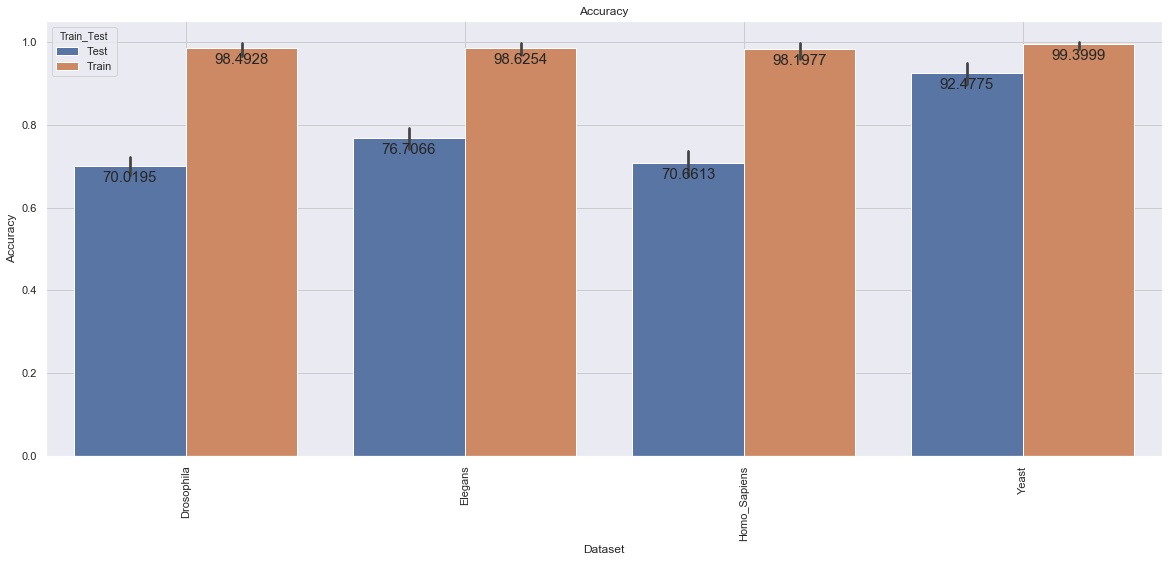

In [15]:
##################################################################################
##### Visualize with a multiple Bar chart
##################################################################################

# df = evaluations_df_grouped[np.in1d(evaluations_df_grouped.index.get_level_values(0), [dataset_to_print])]
# df = evaluations_df_grouped.reset_index(level=['Dataset', 'Encoding_Type', 'Train_Test'])
df = evaluations_df_grouped.reset_index()

# Some boilerplate to initialise things
sns.set()
plt.figure(figsize=(20,8))

# Draw the bars
ax = sns.barplot(data=df, x="Dataset", y=metric_to_plot, hue="Train_Test")

# Customise some display properties
ax.set_title(metric_to_plot)
ax.grid(color='#cccccc')
ax.set_ylabel(metric_to_plot)
ax.set_xlabel("Dataset")
ax.set_xticklabels(df["Dataset"].unique().astype(str), rotation='vertical')

for p in ax.patches:
    ax.annotate(format(p.get_height()*100, '.4f'),
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                size=15,
                xytext = (0, -12), 
                textcoords = 'offset points')

##############################

# Ask Matplotlib to show it
plt.show()

### Store all metrics' plots to file

In [ ]:
##################################################################################
##### Iteratively generate comparison plot using every metric
##################################################################################

for metric_to_plot in list(evaluations_df_grouped.columns):
    for dataset_to_print in datasets:
    
        # df = evaluations_df_grouped[np.in1d(evaluations_df_grouped.index.get_level_values(0), [dataset_to_print])]
        # df = evaluations_df_grouped.reset_index(level=['Dataset', 'Encoding_Type', 'Train_Test'])
        df = evaluations_df_grouped.reset_index()

        # Some boilerplate to initialise things
        sns.set()
        plt.figure(figsize=(20,8))

        # Draw the bars
        ax = sns.barplot(data=df, x="Dataset", y=metric_to_plot, hue="Train_Test")

        # Customise some display properties
        ax.set_title(dataset_to_print)
        ax.grid(color='#cccccc')
        ax.set_ylabel(metric_to_plot)
        ax.set_xlabel("Dataset")
        ax.set_xticklabels(df["Dataset"].unique().astype(str), rotation='vertical')

        for p in ax.patches:
            ax.annotate(format(p.get_height()*100, '.4f'),
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = 'center', va = 'center', 
                        size=15,
                        xytext = (0, -12), 
                        textcoords = 'offset points')
        
        plt.savefig(os.path.join(evalPath, "{}_{}_{}_Comparison".format(metric_to_plot, dataset_to_print, modelNames[0])))
        plt.close()
    